In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/Utils")


In [2]:
import warnings
import gc
import numpy as np
import pandas as pd
import dask.dataframe as dd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Diferenças em Diferenças

### Investigando efeito das políticas estaduais de distribuição de chips e equipamentos frente estados que não realizaram intervenções durante a pandemia

Para calcular o efeito a partir da abordagem de diferenças em diferenças, utilizamos a seguinte equação:

$\hat{y} = \beta_0 + \beta_1 \times Treated + \beta_2 \times Post + \beta_3 \times Treated \times Post + \beta_i \times Cofound_i + ... + \beta_n \times Cofound_n$

Controlando para demais variáveis que produzam impacto no outcome. O efeito obtido então da política será o regressor $\beta_3$.

### Hipótese: 

Políticas de intervenção e subsídio ao acesso de internet amenizaram o impacto negativo do ensino remoto ao fornecer acesso a estudantes vulneráveis.

### Proxy para Tratamento:

Como não existem dados oficiais dos estados sobre a distribuição de chips e equipamentos por escola, utilizamos uma proxy dada pela probabilidade de cada aluno receber chips e equipamentos para cada município.

Essa probabilidade será calculada a partir da seguinte equação:

$E[Chip_ik] = \frac{(\dot{y_i} / n_k)(1 - b)}{a}$

- $E[Chip_i]$ é a probabilidade do aluno $i$ do município $k$ receber um chip/equipamento do governo;
- $\dot{y_i}$ é o número de chips/equipamentos distribuídos para o município $i$;
- $n_k$ é o número de alunos das escolas elegíveis para a política no município $k$;
- $a$ é a probabilidade de erro tipo-I: que o estudante receba acesso a internet mas não seja contabilizado na proxy;
- $b$ é a probabilidade de erro tipo-II: que o estudante não receba acesso a internet mesmo tendo cobertura no município;


# Análise empírica

To-do:

- Coletar informações sobre a distribuição de chips e equipamentos por município com data do início da política e mais detalhes;
- Plotar gráficos com a diferença entre o grupo de controle e de tratamento e a evolução nas notas médias, de português e matemática, de cada grupo no tempo;
- Construir proxy para tratamento;
- Realizar regressão e obter os estimadores de diferenças em diferenças;

In [3]:
from funs import *
from cols_list import cols_enem

## Funções

In [4]:
def agg_home_conditions(df):
    '''
    Cria um índice normalizado que representa a condição de moradia do aluno.
    '''

    mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5}
    cols = ['Q007','Q008','Q009','Q010','Q012','Q014','Q016','Q019']
    for col in cols:
        df[col] = df[col].map(mapping, meta=(col, 'int'))

    series = df['Q007'] + df['Q008'] + \
    df['Q009'] + df['Q010'] + df['Q012'] + \
    df['Q014'] + df['Q016'] + df['Q019'] 
    
    min = series.min().compute()
    max = series.max().compute()

    normalized = series.apply(lambda x: x-min / max-min, meta=series)

    return normalized

In [5]:
def load_and_filter(year):
    '''
    Carrega um ano específico do dataset do ENEM, realiza a 
    filtragem das colunas e insere dados úteis para a análise.
    
    Parameters
    ----------
    year: int
        The year of the data to be loaded

    Returns
    -------
    df: dask.dataframe
        The filtered data
    '''
    cols_to_use = cols_enem + ['Q014', 'Q016']
    enem = filter_enem(dask_load_year_enem(year, cols_to_use))
    gc.collect()
    enem['Q025'] = enem['Q025'].replace(['A','B'],[0,1])
    enem['NT_MEDIA'] = enem.apply(lambda row: get_medium_score(row), axis=1)
    enem['LOG_NT_MEDIA'] = np.log(enem['NT_MEDIA'])
    enem['LOG_NT_MT'] = np.log(enem['NU_NOTA_MT'])

    try:
        enem['IND_CASA'] = agg_home_conditions(enem)
    except Exception as e:
        print(e)
        print("Error on year {}".format(year))
        raise

    cleared = enem[['NU_ANO','CO_MUNICIPIO_ESC',
    'SG_UF_ESC','TP_DEPENDENCIA_ADM_ESC', 
    'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
    'TP_COR_RACA', 'TP_ESCOLA', 'TP_LOCALIZACAO_ESC','LOG_NT_MT','NU_NOTA_LC',
    'NU_NOTA_MT','Q001', 'Q002', 'Q005', 'Q006', 'Q022', 'Q024', 'Q025', 'IND_CASA', 'NT_MEDIA',
    'LOG_NT_MEDIA']]
    
    return cleared

## Processamento e modelagem

In [6]:
data = dd.concat([load_and_filter(year) for year in range(2018,2022)])

Tamanho do dataset pré-filtragem:  5513733
Tamanho do dataset pós-filtragem:  1706963
Taxa de filtragem:  0.6904160937789334


/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/dask/dataframe/core.py:5408: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arra

Tamanho do dataset pré-filtragem:  5095171
Tamanho do dataset pós-filtragem:  1604459
Taxa de filtragem:  0.6851020309230054


/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/dask/dataframe/core.py:5408: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arra

Tamanho do dataset pré-filtragem:  5783109
Tamanho do dataset pós-filtragem:  1254237
Taxa de filtragem:  0.7831206363220891


/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/dask/dataframe/core.py:5408: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arra

Tamanho do dataset pré-filtragem:  2685053
Tamanho do dataset pós-filtragem:  950911
Taxa de filtragem:  0.6458501936460844


/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/dask/dataframe/core.py:5408: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arra

In [7]:
data = data.compute()

/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joao/anaconda3

In [9]:
# persistindo dados para sessão posterior
data.to_parquet('../../Resultados/Agg/ENEM/aux/dados_para_modelagem.parquet')

### Plotando evolução nas notas: controle x tratamento

In [8]:
data.columns

Index(['NU_ANO', 'CO_MUNICIPIO_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_ESCOLA', 'TP_LOCALIZACAO_ESC', 'LOG_NT_MT', 'NU_NOTA_LC',
       'NU_NOTA_MT', 'Q001', 'Q002', 'Q005', 'Q006', 'Q022', 'Q024', 'Q025',
       'IND_CASA', 'NT_MEDIA', 'LOG_NT_MEDIA'],
      dtype='object')

In [9]:
a_b = data.query('TP_DEPENDENCIA_ADM_ESC == 2 and TP_LOCALIZACAO_ESC == 1')[['NU_ANO', 'SG_UF_ESC', 'NT_MEDIA', 'LOG_NT_MEDIA','LOG_NT_MT', 'NU_NOTA_MT','NU_NOTA_LC']]

In [10]:
# Comparando Bahia (não tratado) e Ceará (tratado)
a_b = a_b.query('SG_UF_ESC == "PI" or SG_UF_ESC == "CE" or SG_UF_ESC == "BA" or SG_UF_ESC == "MA" or SG_UF_ESC == "PE" or SG_UF_ESC == "RN" or SG_UF_ESC == "SE"')
a_b.reset_index(inplace=True, drop=True)
a_b['NU_ANO'] = a_b['NU_ANO'].astype(int)

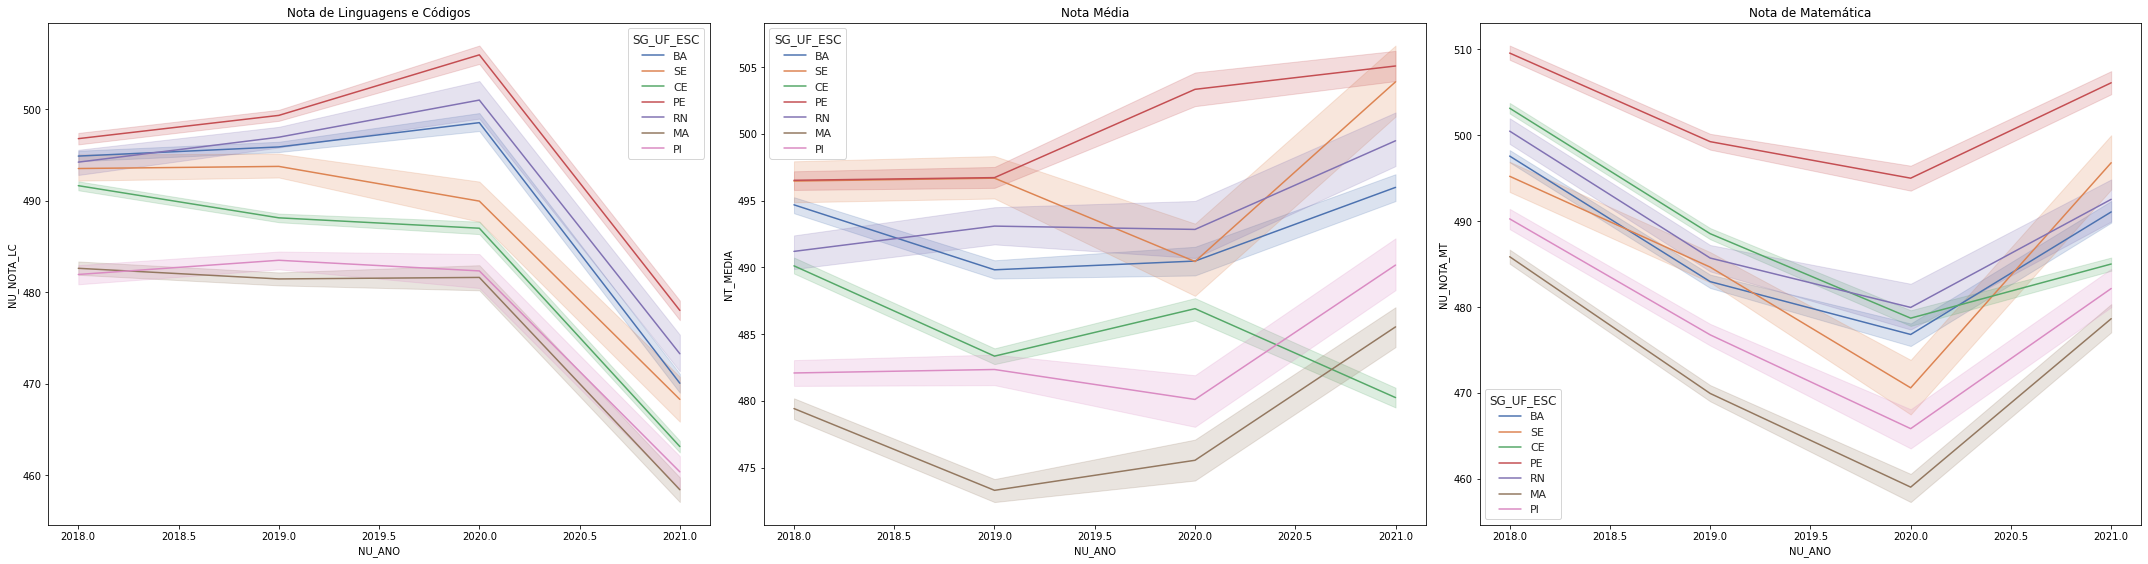

In [11]:
fig, ax = plt.subplots(1,3, figsize=(30, 8))
ax = ax.flatten()
sns.set_theme(style="whitegrid")

ax[0] = sns.lineplot(data=a_b, x='NU_ANO', y='NU_NOTA_LC', hue='SG_UF_ESC', ax=ax[0])
ax[0].set_title('Nota de Linguagens e Códigos')
ax[1] = sns.lineplot(data=a_b, x='NU_ANO', y='NT_MEDIA', hue='SG_UF_ESC', ax=ax[1])
ax[1].set_title('Nota Média')
ax[2] = sns.lineplot(data=a_b, x='NU_ANO', y='NU_NOTA_MT', hue='SG_UF_ESC', ax=ax[2])
ax[2].set_title('Nota de Matemática')

plt.tight_layout()
plt.show()

Sem efeito visual claro nas notas. Porém, isso não é significativo visto que há seleções distintas das amostras

In [12]:
internet = data.query('TP_DEPENDENCIA_ADM_ESC == 2 and TP_LOCALIZACAO_ESC == 1')[['NU_ANO', 'SG_UF_ESC', 'Q025']]
internet = internet.query('SG_UF_ESC == "PI" or SG_UF_ESC == "CE" or SG_UF_ESC == "BA" or SG_UF_ESC == "MA" or SG_UF_ESC == "PE" or SG_UF_ESC == "RN" or SG_UF_ESC == "SE" or SG_UF_ESC == "PA"')
internet.reset_index(inplace=True, drop=True)
internet['NU_ANO'] = internet['NU_ANO'].astype(int)

In [13]:
internet

,NU_ANO,SG_UF_ESC,Q025
0,2018,BA,0.0
1,2018,PA,0.0
2,2018,SE,1.0
3,2018,BA,0.0
4,2018,PA,1.0
...,...,...,...
954596,2021,CE,1.0
954597,2021,BA,1.0
954598,2021,PE,1.0
954599,2021,PE,1.0


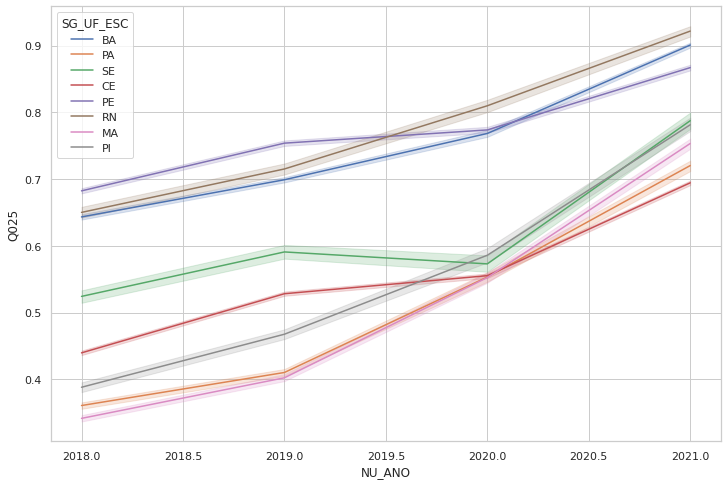

In [14]:
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=internet, x='NU_ANO', y='Q025', hue='SG_UF_ESC');

É perceptível um aumento mais acentuado no acesso à internet no Maranhão, Piauí e Pará (tratados), constrastando com a tendência da Bahia, Rio Grande do Norte e Pernambuco (não-tratados).

### Ajustes na modelagem

Visualmente, a comparação entre estados com tratamento e sem tratamento não é clara. Porém. podemos realizar o ajuste em regressão para contornar os problemas da seleção amostral por meio do matching e verificar o estimador. 

Outra ideia possível é utilizar o modelo de diferenças em diferenças para estimar o efeito da política na presença de internet em casa. A partir desse estimador obtido, podemos inserir essa variável como instrumento na regressão original para analisar o efeito causal entre presença de internet e notas.

(1):

$Nota_i = \beta_0 + \beta_1 \times Cofound_1 + ... + \beta_n \times Cofound_n  + \mathbf{X_i \times INTERNET_i} + e_i$ 

(2):

$\mathbf{INTERNET_i} = \gamma_0 + \gamma_1 \times Treated + \gamma_2 \times Post + \gamma_3 \times Treated \times Post +  ... + \gamma_n \times Cofound_n$

## DiDs

Datas das edições do Enem
- 2019: 03/11/2019 e 10/11/2019
- 2020: 17/01/2021 e 24/01/2021  
- 2021: 21/11/2021 e 28/11/2021
- 2022: 13/11/2022 e 20/11/2022

Como estou relacionando política e presença de internet, posso utilizar como tratados os alunos que receberam chips em 2020 já na edição do enem 2020.
Os que receberam chips em janeiro de 2021 não serão considerados como tratados na edição de 2020, pois não houve tempo suficiente para que a distribuição tenha sido concluída. Estes, serão considerados como tratados apenas em 2021.

In [15]:
import statsmodels.api as sm

In [26]:
data = data.query('TP_LOCALIZACAO_ESC == 1 and TP_DEPENDENCIA_ADM_ESC == 2')

In [54]:
# Para estabelecer a comparação, irei comparar apenas estados do Nordeste e Norte
data = data[data['SG_UF_ESC'].isin(['PI', 'CE', 'BA', 'MA', 'PE', 'RN', 'SE', 'PA','AL', 'RR', 'AM','AC','RO','TO','AP','PA'])]

In [27]:
data['time'] = np.where(

        ((data['SG_UF_ESC'].isin(['MA', 'CE', 'PA'])) & (data['NU_ANO'] > 2019)) 
        |
        ((data['SG_UF_ESC'] == 'PI') & (data['NU_ANO'] > 2020)), 
     1, 
     0)

In [28]:
data['treated'] = np.where(data['SG_UF_ESC'].isin(['MA', 'CE', 'PA', 'PI']), 1, 0)

In [29]:
data['did'] = data['time'] * data['treated']

In [48]:
data.dropna(subset=['Q025'], inplace=True)

In [61]:
data['NAO_BRANCO'] = np.where(~data['TP_COR_RACA'].isin([1,4]), 1, 0)

In [75]:
y = data['Q025']
x = data[['time', 'treated', 'did', 'NAO_BRANCO', 'IND_CASA', 'Q006']]

In [76]:
x.Q006 = x.Q006.replace(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','X','Y','Z'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
x.Q006 = x.Q006.fillna(0)

In [77]:
x.IND_CASA = x.IND_CASA.fillna(0)
x.IND_CASA = x.IND_CASA.apply(lambda x: np.round(x, 2))

In [78]:
print('y:', y.isna().any())
print('x', x.isna().any())

y: False
x time          False
treated       False
did           False
NAO_BRANCO    False
IND_CASA      False
Q006          False
dtype: bool


In [83]:
y = y.astype(int)

In [87]:
X = sm.add_constant(x)
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   Q025   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                 4.211e+04
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:27:00   Log-Likelihood:            -5.9313e+05
No. Observations:              957853   AIC:                         1.186e+06
Df Residuals:                  957847   BIC:                         1.186e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1329      0.002     69.559      0.0

NameError: name 'AC' is not defined

In [92]:
data.groupby('SG_UF_ESC')['did'].value_counts(normalize=True)

SG_UF_ESC  did
AC         0      1.000000
AL         0      1.000000
AM         0      1.000000
AP         0      1.000000
BA         0      1.000000
CE         0      0.686883
           1      0.313117
MA         0      0.799180
           1      0.200820
PA         0      0.782767
           1      0.217233
PE         0      1.000000
PI         0      1.000000
RN         0      1.000000
RO         0      1.000000
RR         0      1.000000
SE         0      1.000000
TO         0      1.000000
Name: did, dtype: float64